In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from keras import layers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.applications import MobileNet
from keras.regularizers import l2

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install tensorflow
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 8.6 MB/s eta 0:00:00


In [6]:
!nvidia-smi

Thu May 25 13:54:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


In [200]:
BATCHES = [16, 32, 64, 128]
PATH = "/content/drive/MyDrive/Datasets/Garbage_Classification"

(TRAIN, VAL) = image_dataset_from_directory(
    PATH,
    labels = "inferred",
    label_mode = "categorical",
    batch_size = BATCHES[1],
    image_size = (224, 224),
    seed = 42,
    subset = "both",
    validation_split = 0.2
)

Found 1393 files belonging to 3 classes.
Using 1115 files for training.
Using 278 files for validation.


In [222]:
# MobileNet Candidate Model

INPUT_SHAPE = (224, 224, 3)
ACTIVATION = "sigmoid"

BASE = MobileNet(weights = "imagenet", include_top = False, input_shape = INPUT_SHAPE)

BASE.trainable = False

x = BASE.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)  # Add additional dense layer if desired
predictions = layers.Dense(3, activation = ACTIVATION)(x)

model = keras.models.Model(inputs = BASE.input, outputs = predictions)

In [223]:
# Model Building
INPUT_SHAPE = (224, 224, 3)
ACTIVATION = "sigmoid"

# MobileNet
BASE = MobileNet(weights = "imagenet", include_top = False, input_shape = INPUT_SHAPE)

BASE.trainable = False

x = BASE.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dropout(0.25)(x)
predictions = layers.Dense(3, activation = ACTIVATION)(x)

MODEL = keras.models.Model(inputs = BASE.input, outputs = predictions)

In [224]:
DATA_GEN_LAYER = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape = INPUT_SHAPE),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
  ]
)

MODEL = keras.Sequential()
MODEL.add(DATA_GEN_LAYER)

BASE = MobileNet(weights = "imagenet", include_top = False, input_shape = INPUT_SHAPE)
BASE.trainable = False

MODEL.add(BASE)
MODEL.add(layers.GlobalAveragePooling2D())
MODEL.add(layers.Dense(64, activation = "relu"))
MODEL.add(layers.Dropout(0.25))
MODEL.add(layers.Dense(3, activation = ACTIVATION))

MODEL.summary()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_86 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_18  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_211 (Dense)           (None, 64)                65600     
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_212 (Dense)           (None, 3)               

In [225]:
# Compiling & Hyperparameter Tuning
LR = [0.0001, 0.001, 0.01, 0.1]
OPTIMIZER = keras.optimizers.Adam(learning_rate = LR[1])

MODEL.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)
MODEL.summary()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_86 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_18  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_211 (Dense)           (None, 64)                65600     
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_212 (Dense)           (None, 3)               

In [226]:
# Model Training
EPOCHS = [50, 100, 150, 200, 250]
BATCHES = [16, 32, 64, 128]

HISTORY = MODEL.fit(
    TRAIN,
    batch_size = BATCHES[1],
    epochs = EPOCHS[0],
    validation_data = VAL,
    # callbacks = EarlyStopping(monitor = "val_loss")
)

Epoch 1/50
35/35 [==============================] - 8s 141ms/step - loss: 1.0615 - accuracy: 0.4664 - val_loss: 0.9056 - val_accuracy: 0.5899
Epoch 2/50
35/35 [==============================] - 4s 89ms/step - loss: 0.8844 - accuracy: 0.5901 - val_loss: 0.9264 - val_accuracy: 0.5755
Epoch 3/50
35/35 [==============================] - 4s 108ms/step - loss: 0.8250 - accuracy: 0.6287 - val_loss: 0.8705 - val_accuracy: 0.6151
Epoch 4/50
35/35 [==============================] - 4s 91ms/step - loss: 0.7959 - accuracy: 0.6457 - val_loss: 0.8123 - val_accuracy: 0.6403
Epoch 5/50
35/35 [==============================] - 4s 88ms/step - loss: 0.7442 - accuracy: 0.6682 - val_loss: 0.7969 - val_accuracy: 0.6439
Epoch 6/50
35/35 [==============================] - 4s 108ms/step - loss: 0.7572 - accuracy: 0.6700 - val_loss: 0.7766 - val_accuracy: 0.6403
Epoch 7/50
35/35 [==============================] - 4s 92ms/step - loss: 0.7347 - accuracy: 0.6744 - val_loss: 0.8065 - val_accuracy: 0.6367
Epoch 8/50

In [227]:
HISTORY.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [235]:
# Grid Search CV
PARAMS = {
    "epochs": [50, 100, 150, 200, 250],
    "batch_size": [16, 32, 64, 128],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "optimizer": ["SGD", "adam", "rmsprop", "adagrad"]
}

GSCV = GridSearchCV(
    estimator = MODEL,
    param_grid = PARAMS,
    scoring = "accuracy",
    cv = 10,
)

In [228]:
MODEL.save("/content/drive/MyDrive/Models/Model_1.h5")

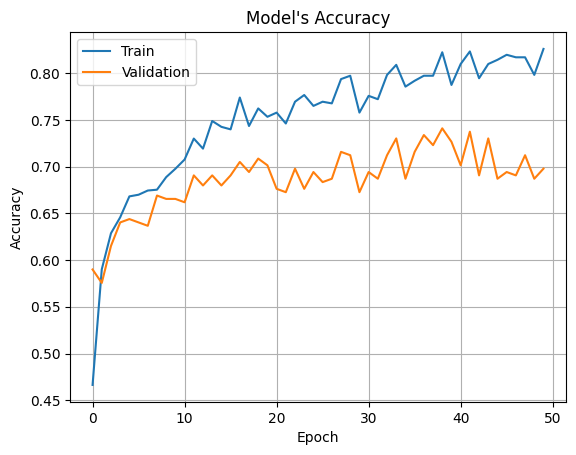

In [229]:
# Accuracy Plot
plt.plot(HISTORY.history["accuracy"])
plt.plot(HISTORY.history["val_accuracy"])
plt.title("Model\'s Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.grid()
plt.show()

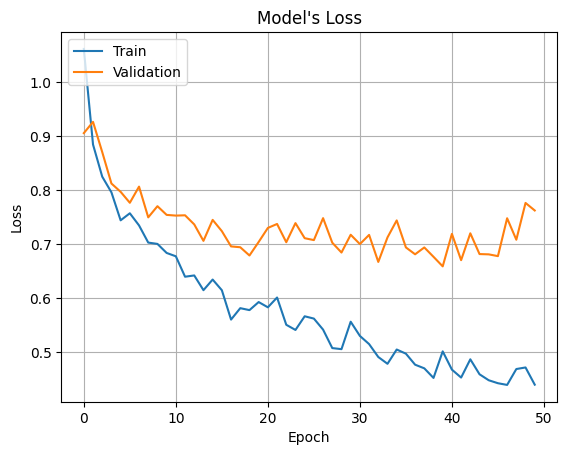

In [230]:
# Loss Plot
plt.plot(HISTORY.history["loss"])
plt.plot(HISTORY.history["val_loss"])
plt.title("Model\'s Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.grid()
plt.show()